pyFFTW not found, using Numpy FT.


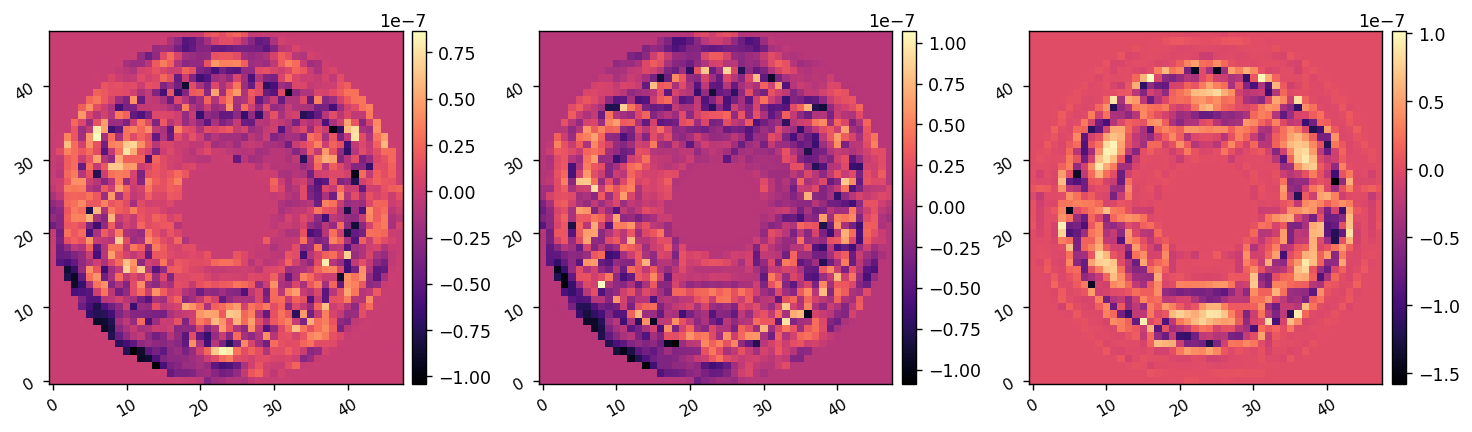

In [5]:
import numpy as np
import astropy.io.fits as fits
import astropy.units as u
import matplotlib.pyplot as plt
from matplotlib.patches import Circle

from IPython.display import clear_output, display
import time
from pathlib import Path
import copy

import proper
proper.prop_use_fftw(DISABLE=False)

import roman_phasec_proper

import cgi_phasec_poppy as cgi
import cgi_phasec_poppy.imshows as imshows
from cgi_phasec_poppy.imshows import *
import ray

import misc_funs as misc

data_dir = Path('/groups/douglase/kians-data-files/disk-processing')
data_dir = Path('/npool/nvme/kianmilani/disk-data')

dm1_best = fits.getdata(roman_phasec_proper.lib_dir + r'/examples/hlc_best_contrast_dm1.fits')
dm2_best = fits.getdata(roman_phasec_proper.lib_dir + r'/examples/hlc_best_contrast_dm2.fits')

imshow3(dm1_best, dm2_best, dm1_best-dm2_best)

In [2]:
wavelength_c = 575e-9*u.m
D = 2.3631*u.m
mas_per_lamD = (wavelength_c/D*u.radian).to(u.mas)

npsf = 64
psf_pixelscale = 13e-6
psf_pixelscale_lamD = 500/575 * 1/2
psf_pixelscale_mas = psf_pixelscale_lamD*mas_per_lamD/u.pix

iwa = 3
owa = 9

# Create the sampling grid the PSFs will be made on
sampling1 = 0.05
sampling2 = 0.1
sampling3 = 0.25
offsets1 = np.arange(0,iwa+1,sampling1)
offsets2 = np.arange(iwa+1,owa,sampling2)
offsets3 = np.arange(owa,15+sampling3,sampling3)

r_offsets = np.hstack([offsets1, offsets2, offsets3])
nr = len(r_offsets)
r_offsets_mas = r_offsets*mas_per_lamD
display(nr, r_offsets)

sampling_theta = 6
thetas = np.arange(0,360,sampling_theta)*u.deg
nth = len(thetas)
display(nth, thetas)

psfs_required = (nr-1)*nth + 1
display(psfs_required)

# r_offsets_hdu = fits.PrimaryHDU(data=r_offsets)
# r_offsets_fpath = data_dir/'psfs'/'hlc_band1_psfs_radial_samples_20230501.fits'
# r_offsets_hdu.writeto(r_offsets_fpath, overwrite=True)

# thetas_hdu = fits.PrimaryHDU(data=thetas.value)
# thetas_fpath = data_dir/'psfs'/'hlc_band1_psfs_theta_samples_20230501.fits'
# thetas_hdu.writeto(thetas_fpath, overwrite=True)


155

array([ 0.  ,  0.05,  0.1 ,  0.15,  0.2 ,  0.25,  0.3 ,  0.35,  0.4 ,
        0.45,  0.5 ,  0.55,  0.6 ,  0.65,  0.7 ,  0.75,  0.8 ,  0.85,
        0.9 ,  0.95,  1.  ,  1.05,  1.1 ,  1.15,  1.2 ,  1.25,  1.3 ,
        1.35,  1.4 ,  1.45,  1.5 ,  1.55,  1.6 ,  1.65,  1.7 ,  1.75,
        1.8 ,  1.85,  1.9 ,  1.95,  2.  ,  2.05,  2.1 ,  2.15,  2.2 ,
        2.25,  2.3 ,  2.35,  2.4 ,  2.45,  2.5 ,  2.55,  2.6 ,  2.65,
        2.7 ,  2.75,  2.8 ,  2.85,  2.9 ,  2.95,  3.  ,  3.05,  3.1 ,
        3.15,  3.2 ,  3.25,  3.3 ,  3.35,  3.4 ,  3.45,  3.5 ,  3.55,
        3.6 ,  3.65,  3.7 ,  3.75,  3.8 ,  3.85,  3.9 ,  3.95,  4.  ,
        4.1 ,  4.2 ,  4.3 ,  4.4 ,  4.5 ,  4.6 ,  4.7 ,  4.8 ,  4.9 ,
        5.  ,  5.1 ,  5.2 ,  5.3 ,  5.4 ,  5.5 ,  5.6 ,  5.7 ,  5.8 ,
        5.9 ,  6.  ,  6.1 ,  6.2 ,  6.3 ,  6.4 ,  6.5 ,  6.6 ,  6.7 ,
        6.8 ,  6.9 ,  7.  ,  7.1 ,  7.2 ,  7.3 ,  7.4 ,  7.5 ,  7.6 ,
        7.7 ,  7.8 ,  7.9 ,  8.  ,  8.1 ,  8.2 ,  8.3 ,  8.4 ,  8.5 ,
        8.6 ,  8.7 ,

60

<Quantity [  0.,   6.,  12.,  18.,  24.,  30.,  36.,  42.,  48.,  54.,
            60.,  66.,  72.,  78.,  84.,  90.,  96., 102., 108., 114.,
           120., 126., 132., 138., 144., 150., 156., 162., 168., 174.,
           180., 186., 192., 198., 204., 210., 216., 222., 228., 234.,
           240., 246., 252., 258., 264., 270., 276., 282., 288., 294.,
           300., 306., 312., 318., 324., 330., 336., 342., 348., 354.] deg>

9241

Text(0.5, 1.0, 'Distribution of PRFs')

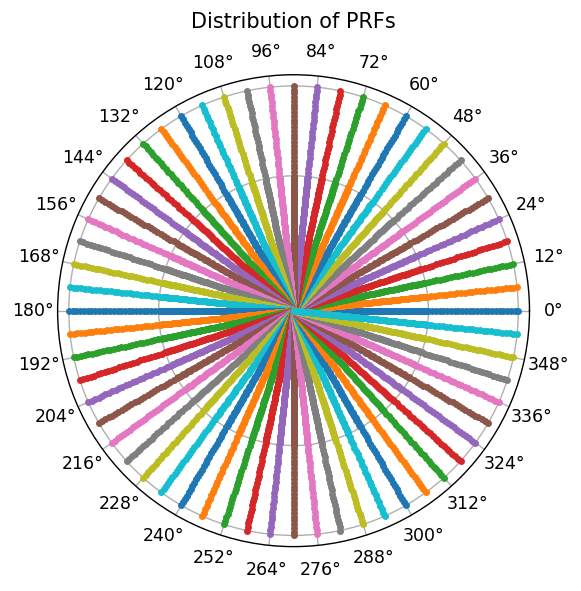

In [3]:
# Plotting field angles
theta_offsets = []
for r in r_offsets[1:]:
    theta_offsets.append(thetas.to(u.radian).value)
theta_offsets = np.array(theta_offsets)
theta_offsets.shape

fig = plt.figure(dpi=125, figsize=(5,5))

ax1 = plt.subplot(111, projection='polar')
ax1.plot(theta_offsets, r_offsets[1:], '.')
ax1.set_rticks([iwa, owa, max(r_offsets)], linewidth=4)  # Less radial ticks
# ax1.set_rticks([])  # Less radial ticks
ax1.set_yticklabels([])
ax1.set_thetagrids(thetas[::2].value)
ax1.set_rlabel_position(55)  # Move radial labels away from plotted line
ax1.grid(True)
ax1.set_title('Distribution of PRFs', va='bottom')

In [6]:
94/28

3.357142857142857

In [7]:
rayCGI = ray.remote(cgi.PROPERCGI)

nlam = 7
bandwidth = 0.10
minlam = wavelength_c * (1 - bandwidth/2)
maxlam = wavelength_c * (1 + bandwidth/2)
wavelengths = np.linspace( minlam, maxlam, nlam )

npol = 4
polaxis = np.array([-2, -1, 1, 2])

mode_settings = {
    'cgi_mode':'hlc',
    'use_pupil_defocus':True,    
    'use_opds':True,
}

actors = []
for i in range(nlam):
    for j in range(npol):
        actors.append(rayCGI.options(num_cpus=3).remote(wavelength=wavelengths[i],
                                                        polaxis=polaxis[j], 
                                                        **mode_settings))

In [4]:
rayCGI = ray.remote(cgi.PROPERCGI)

nlam = 7
bandwidth = 0.10
minlam = wavelength_c * (1 - bandwidth/2)
maxlam = wavelength_c * (1 + bandwidth/2)
wavelengths = np.linspace( minlam, maxlam, nlam )

polaxis = 10

mode_settings = {
    'cgi_mode':'hlc',
    'use_pupil_defocus':True,    
    'use_opds':True,
}

actors = []
for i in range(nlam):
    actors.append(rayCGI.options(num_cpus=3).remote(wavelength=wavelengths[i],
                                                        polaxis=10, 
                                                        **mode_settings))

In [5]:
hlc = cgi.multiCGI(actors)

hlc.set_dm1(dm1_best)
hlc.set_dm2(dm2_best)

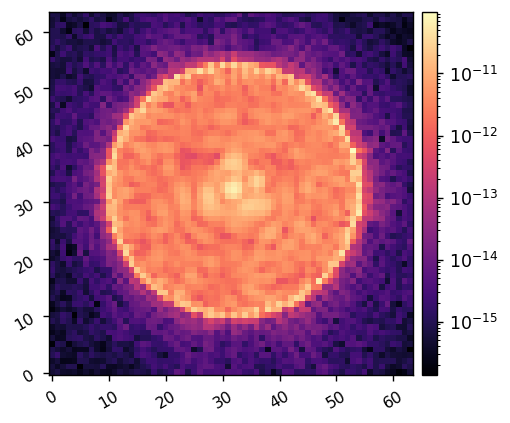

In [6]:
im = hlc.snap()
misc.imshow1(im, lognorm=True)

(9241, 64, 64)


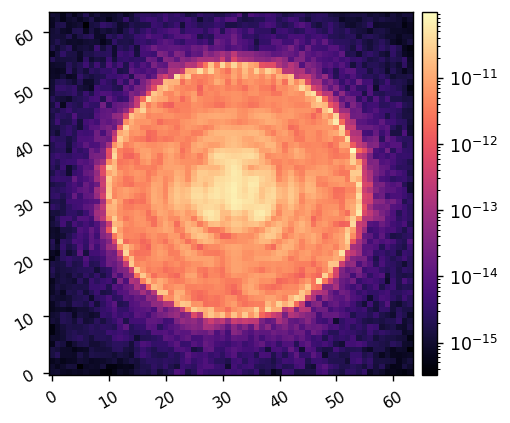

0
(r,theta) = (0.0, 0.0)
(x,y) = (0.0, 0.0)
computation time =  14.71239686012268


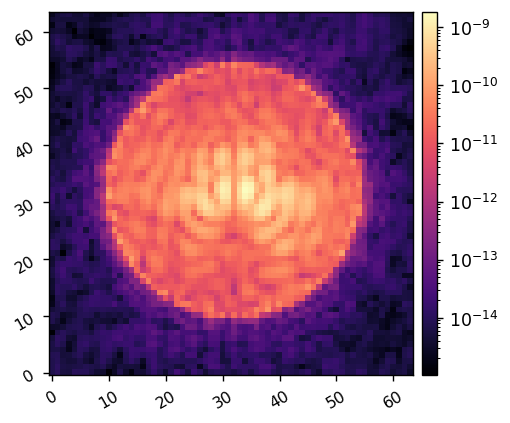

1
(r,theta) = (0.05, 0.0)
(x,y) = (0.05, 0.0)
computation time =  30.017799377441406


KeyboardInterrupt: 

In [9]:
start = time.time()

psfs_array = np.zeros( shape=( (nr-1)*nth + 1, npsf,npsf) )
print(psfs_array.shape)

count = 0
for i,r in enumerate(r_offsets): 
    for j,th in enumerate(thetas):
        xoff = r*np.cos(th)
        yoff = r*np.sin(th)

        hlc.source_offset((xoff.value,yoff.value))
        psf = hlc.snap()
        misc.imshow1(psf, lognorm=True)
        print(count) 
        print('(r,theta) =', (r, th.value))
        print('(x,y) =', (xoff.value, yoff.value))
        print('computation time = ', time.time()-start)
        
        if r<r_offsets[1]: 
            psfs_array[0] = psf
            count += 1
            break
        else: 
            psfs_array[count] = psf
            
        count += 1

In [11]:
9241*15/3600

38.50416666666667

In [14]:
hdr = fits.Header()
hdr['PXSCLAMD'] = psf_pixelscale_lamD
hdr.comments['PXSCLAMD'] = 'pixel scale in lam0/D per pixel'
hdr['PXSCLMAS'] = psf_pixelscale_mas.value
hdr.comments['PXSCLMAS'] = 'pixel scale in mas per pixel'
hdr['PIXELSCL'] = psf_pixelscale
hdr.comments['PIXELSCL'] = 'pixel scale in meters per pixel'
hdr['CWAVELEN'] = wavelength_c.to_value(u.m)
hdr.comments['CWAVELEN'] = 'central wavelength in meters'
hdr['BANDPASS'] = bandwidth
hdr.comments['BANDPASS'] = 'bandpass as fraction of CWAVELEN'

psfs_hdu = fits.PrimaryHDU(data=psfs_array, header=hdr)

psfs_fpath = data_dir/'psfs'/'hlc_band1_psfs_20230501.fits'
psfs_hdu.writeto(psfs_fpath, overwrite=True)
